In [1]:
%matplotlib inline
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from gravdark import LightCurve, hat7_params
from gravdark.lightcurve import concatenate_light_curves

h7_path = glob('/Users/bmmorris/data/gravdark/hat7/*slc.fits')
h7_lc_whole = LightCurve.from_raw_fits(h7_path, name='HAT-P-7 b')

h7_masked = LightCurve(**h7_lc_whole.mask_out_of_transit(hat7_params(), oot_duration_fraction=0.5))
h7_transits = h7_masked.get_transit_light_curves(hat7_params())
for transit in h7_transits:
    transit.remove_linear_baseline(hat7_params())
h7 = concatenate_light_curves(h7_transits)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:849: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/time/core.py:850: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:373: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:374: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/gravdark/gravdark/lightcurve.py:375: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an er

(0.992, 1.001)

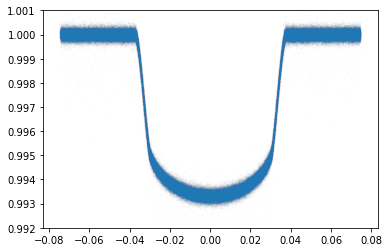

In [2]:
plt.scatter(h7.phases(hat7_params()), h7.fluxes, s=1, alpha=0.01)
plt.ylim([0.992, 1.001])

In [4]:
phase = h7.phases(hat7_params())
residuals = h7.fluxes - h7.transit_model(hat7_params())

binstat = binned_statistic(phase, residuals, statistic='median', bins=100)
bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

(-0.0001, 0.0001)

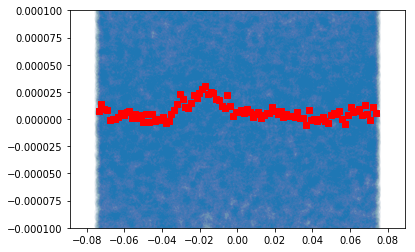

In [5]:
plt.scatter(phase, residuals, alpha=0.01)
plt.scatter(bincenters, binstat.statistic, marker='s', color='r')
plt.ylim([-0.0001, 0.0001])

In [6]:
# from scipy.optimize import fmin_powell
# import batman

# def tweak_params(p):
#     t0 = p[0]
    
#     params = batman.TransitParams()
#     params.t0 = t0     # time of inferior conjunction
#     params.per = 2.2047355         # orbital period
#     params.rp = 0.077490          # planet radius (in units of stellar radii)
#     dur = 0.1669                  # transit duration
#     params.inc = 83.119             # orbital inclination (in degrees)

#     params.ecc = 0      # eccentricity
#     params.w = np.pi/2               # longitude of periastron (in degrees)
#     params.a = 4.1512                # semi-major axis (in units of stellar radii)
#     params.u = [0.3522, 0.1705]      # limb darkening coefficients
#     params.limb_dark = "quadratic" # limb darkening model

#     # Required by some friedrich methods below but not by batman:
#     params.duration = dur
#     return params
    
# def chi2(p):
#     params = tweak_params(p)
#     sq_diff = (h7.fluxes - h7.transit_model(params))**2
#     return np.sum(sq_diff)

# initp = [54.35780 + 2454900]
# results = fmin_powell(chi2, initp)

In [7]:
from gravdark.systemparams import transit_duration

transit_duration(hat7_params())

0.16413983709319213

In [8]:
min_phase = -0.035
max_phase = 0

phase = h7.phases(hat7_params())
no_bump = (phase < min_phase) | (phase > max_phase)

transit_lc = LightCurve(times=h7.times.jd[no_bump], 
                        fluxes=h7.fluxes[no_bump],
                        errors=h7.errors[no_bump])

(-0.0001, 0.0001)

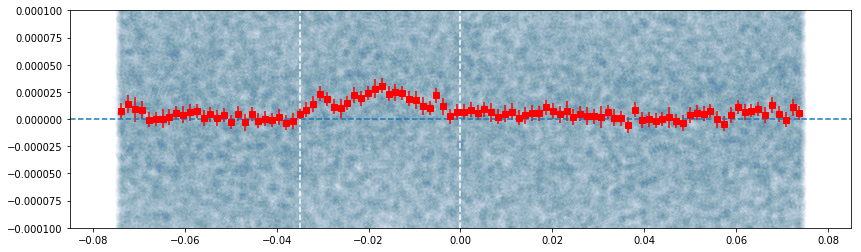

In [9]:
#params = tweak_params([results])
#phase = h7.phases(params)

phase = h7.phases(hat7_params())
residuals = h7.fluxes - h7.transit_model(hat7_params())

binstat = binned_statistic(phase, residuals, statistic='median', bins=100)
errstat = binned_statistic(phase, residuals, statistic='std', bins=100)
countstat = binned_statistic(phase, residuals, statistic='count', bins=100)
error = 2 * errstat.statistic/np.sqrt(countstat.statistic)

bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

plt.figure(figsize=(14, 4))
plt.scatter(phase, residuals, alpha=0.01)
#plt.scatter(bincenters, binstat.statistic, marker='s', color='r')
plt.errorbar(bincenters, binstat.statistic, yerr=error, fmt='s', color='r')
plt.axhline(0, ls='--')

plt.axvline(min_phase, ls='--', color='w')
plt.axvline(max_phase, ls='--', color='w')

plt.ylim([-0.0001, 0.0001])

accept frac = 0.34


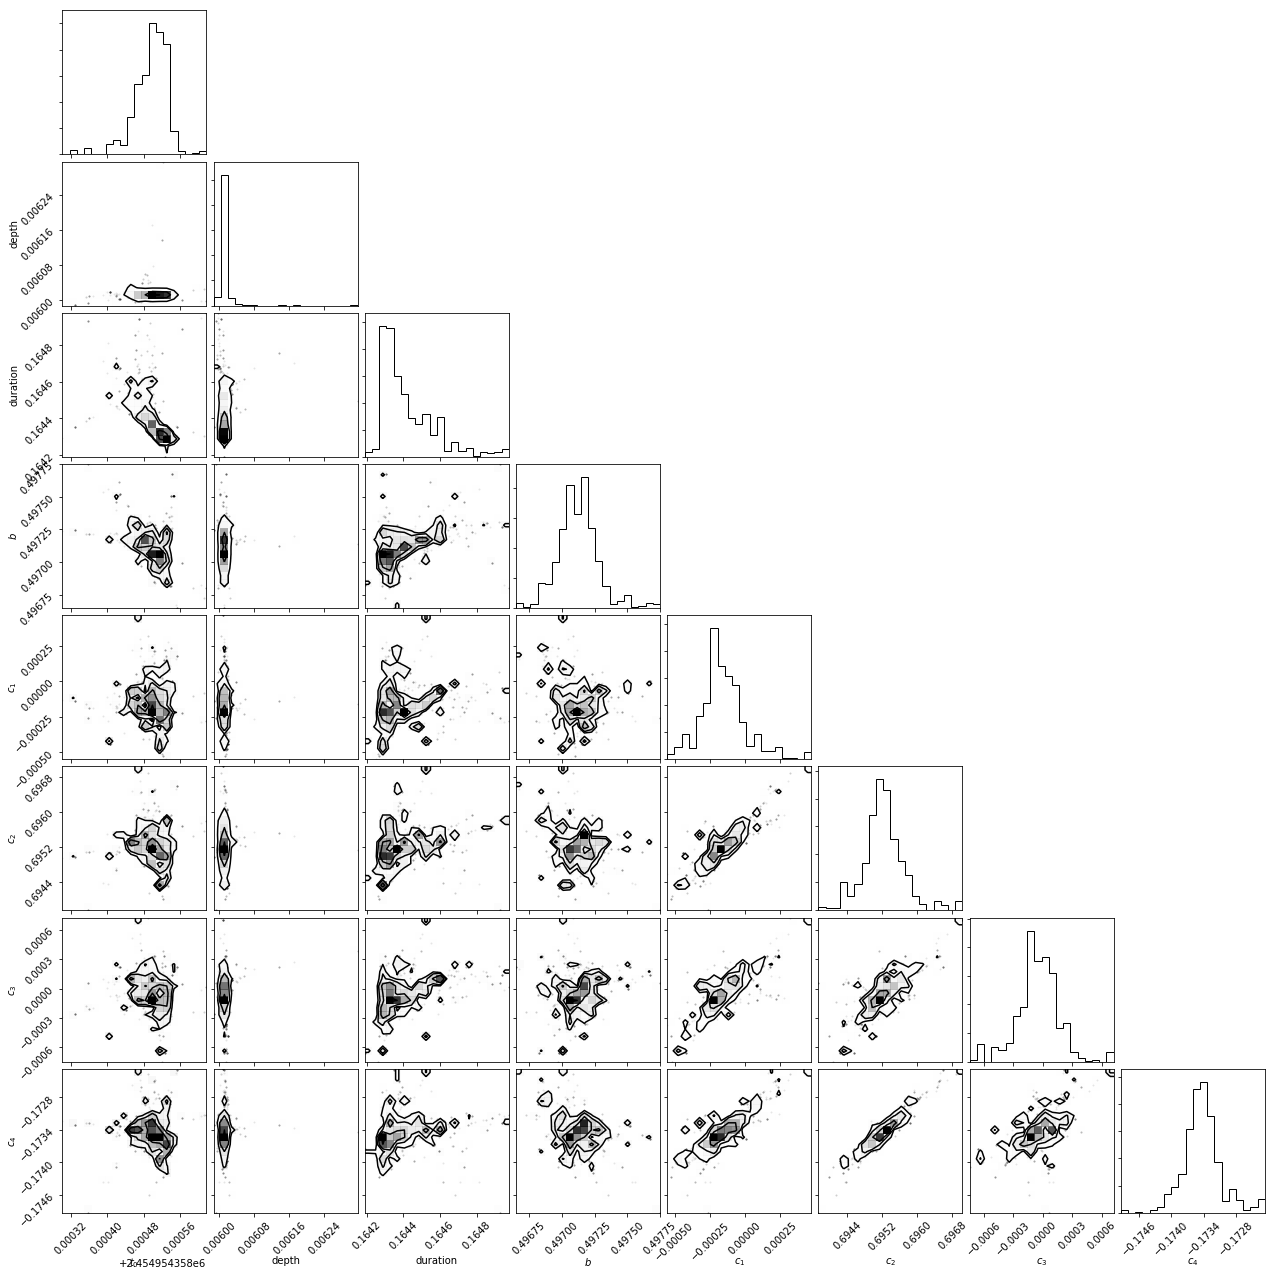

<IPython.core.display.Latex object>

In [12]:
from gravdark.systemparams import aRs_i
from gravdark.fitting import (print_emcee_results, run_emcee, 
                               plot_triangle, run_emcee_ephemeris)

from IPython.display import display_latex, Latex

# Here are initial orbit parameters for the first fits
h7params_init = hat7_params()

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def quadratic_to_kipping(p):
    u1, u2 = p
    q1 = (u1 + u2)**2
    q2 = u1/(2 * (u1 + u2))
    return q1, q2

#q1, q2 = kipping_to_quadratic(h7params_init.u)
#q1, q2 = quadratic_to_kipping(h7params_init.u)
h7params_init.u = [0.0, 0.69500232571371012, 0.0, -0.1733506790071129]
h7params_init.limb_dark = 'nonlinear'
[t0, depth, dur, b, c1, c2, c3, c4] = [h7params_init.t0, h7params_init.rp**2, 
                               h7params_init.duration, h7params_init.b,
                               0.0, 0.69500232571371012, 0.0, -0.1733506790071129]#q1, q2]
p0 = [t0, depth, dur, b, c1, c2, c3, c4]
n_steps = 100
#transit_lc = h7
# n_steps=1000 Takes about ~3 min
samples, sampler = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                             transit_lc.errors, n_steps, h7params_init)
print("accept frac = {0:.2f}".format(np.mean(sampler.acceptance_fraction)))
plot_triangle(samples[:, :])

#print_emcee_results(samples)
Latex(print_emcee_results(samples))

In [258]:
best_fit = sampler.flatchain[np.argmax(sampler.lnprobability)]

from copy import deepcopy

def quadratic_to_nonlinear(u1, u2):
    a1 = a3 = 0
    a2 = u1 + 2*u2
    a4 = -u2
    return (a1, a2, a3, a4)

# dur = hat7_fit_params.per/np.pi * np.arcsin(np.sqrt((1-hat7_fit_params.rp)**2 - 
#                                                      hat7_fit_params.b**2) / 
#                                              ars/np.sin(np.radians(inc)))
hat7_fit_params = deepcopy(hat7_params())
hat7_fit_params.t0 = best_fit[0]
hat7_fit_params.rp = best_fit[1]**0.5
hat7_fit_params.duration = best_fit[2]
hat7_fit_params.b = best_fit[3]
hat7_fit_params.u = best_fit[4:9] #quadratic_to_nonlinear(*best_fit[4:6])
hat7_fit_params.limb_dark = 'nonlinear'

ars, inc = aRs_i(hat7_fit_params)

hat7_fit_params.a = ars
hat7_fit_params.inc = inc


In [267]:
print(["{0:.10f}".format(i) for i in best_fit])

ars, inc

['2454954.3585320301', '0.0060145364', '0.1642824419', '0.4971796183', '-0.0001633606', '0.6950284883', '-0.0001334469', '-0.1735805985']


(4.1512968447903313, 83.121465971608487)

(-0.0001, 0.0001)

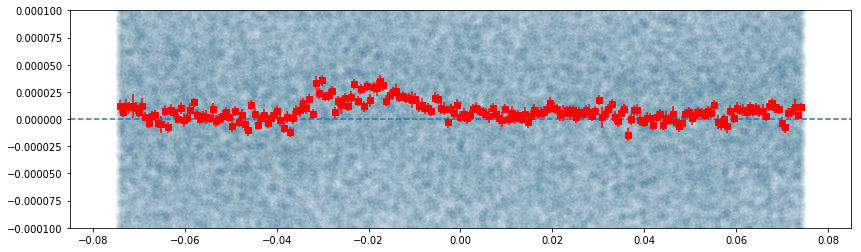

In [15]:
#params = tweak_params([results])
#phase = h7.phases(params)

phase = h7.phases(hat7_fit_params)
residuals = h7.fluxes - h7.transit_model(hat7_fit_params)
bins = np.linspace(phase.min(), phase.max(), phase.ptp()*60*24)

n_bins = phase.ptp() * hat7_fit_params.per * 60*24
binstat = binned_statistic(phase, residuals, statistic='median', bins=bins)
errstat = binned_statistic(phase, residuals, statistic='std', bins=bins)
countstat = binned_statistic(phase, residuals, statistic='count', bins=bins)
error = errstat.statistic/np.sqrt(countstat.statistic)
bincenters = 0.5 * (binstat.bin_edges[1:] + binstat.bin_edges[:-1])

binned_lc = LightCurve(times=bincenters*hat7_fit_params.per + hat7_fit_params.t0, 
                       fluxes=binstat.statistic - np.median(binstat.statistic), 
                       errors=error)

plt.figure(figsize=(14, 4))
plt.scatter(phase, residuals, alpha=0.01)
#plt.scatter(bincenters, binstat.statistic, marker='s', color='r')
plt.errorbar(bincenters, binstat.statistic, yerr=error, fmt='s', color='r')
plt.axhline(0, ls='--')
plt.ylim([-0.0001, 0.0001])

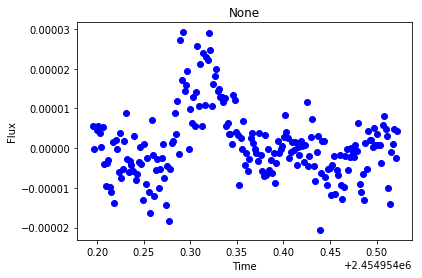

In [16]:
binned_lc.plot()

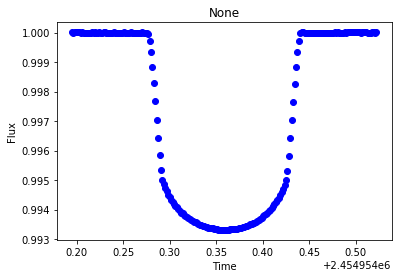

In [17]:
bump_lc = LightCurve(times=binned_lc.times.jd,
                     fluxes=binned_lc.transit_model(hat7_fit_params) + 
                            binned_lc.fluxes - np.median(binned_lc.fluxes),
                     errors=binned_lc.errors)
bump_lc.plot()

In [18]:
np.savetxt('data/hat7.txt', np.vstack([bump_lc.times.jd, bump_lc.fluxes, bump_lc.errors]).T)

In [40]:
' '.join(["{0:.10f}".format(i) for i in hat7_fit_params.u])

'-0.0001633606 0.6950284883 -0.0001334469 -0.1735805985'

In [264]:
hat7_fit_params.inc


83.121465971608487

In [217]:
hat7_fit_params.inclination

AttributeError: 'TransitParams' object has no attribute 'inclination'

In [175]:
# Calculate inclination


In [176]:
dur, inc

(0.13310202890850037, 83.121465971608487)

In [202]:
from astropy.constants import G
from astropy.constants import R_sun, M_sun
import astropy.units as u

krhop = hat7_fit_params.rp**3 * (1.0 * u.g/u.cm**3)
rho_s = 3*np.pi / (G * hat7_fit_params.per**2 * u.day**2) * (ars)**3 - krhop
#rho_s.decompose()
rho_s.to(M_sun/(4./3 * np.pi * R_sun**3)).value

0.19693207619128172

In [154]:
hat7_fit_params.inc

83.143

In [43]:


# http://exoplanets.org/detail/HAT-P-7_b
#(0.2718 *u.g/u.cm**3).to(M_sun/(4./3 * np.pi * R_sun**3)) # 

#((1.47 * M_sun)/(4./3 * np.pi * (1.84*R_sun)**3)).to(M_sun/(4./3 * np.pi * R_sun**3))

In [251]:
from astropy.io import ascii

# tbl = ascii.read('/Users/bmmorris/git/gravdark/stsp/test_lcbest.txt',
tbl = ascii.read('/Users/bmmorris/git/gravdark/stsp/test_lcout.txt',
                 names=['time', 'flux', 'err', 'model', 'flag'])

In [252]:
hat7_fit_params.u

array([ -1.63360639e-04,   6.95028488e-01,  -1.33446916e-04,
        -1.73580598e-01])

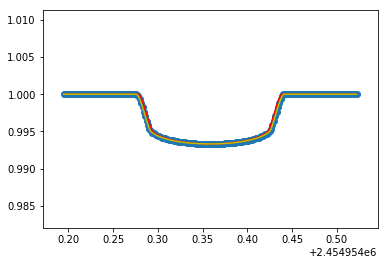

In [253]:
plt.scatter(tbl['time'], tbl['flux'])
plt.plot(tbl['time'], tbl['model'], 'r')
plt.plot(bump_lc.times.jd, bump_lc.transit_model(hat7_fit_params), 'y')

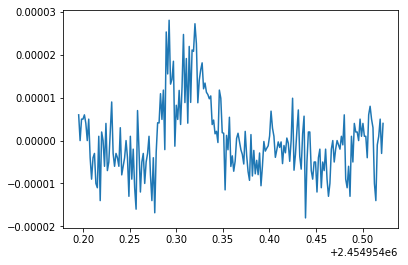

In [254]:
plt.plot(tbl['time'], tbl['flux'] - bump_lc.transit_model(hat7_fit_params))

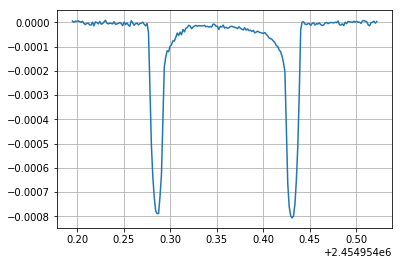

In [255]:
# plt.scatter(tbl['time'], tbl['flux'])
# plt.plot(tbl['time'], tbl['model'], 'r')#binned_lc.transit_model(hat7_fit_params))
plt.grid()
plt.plot(tbl['time'], tbl['flux'] - tbl['model'])

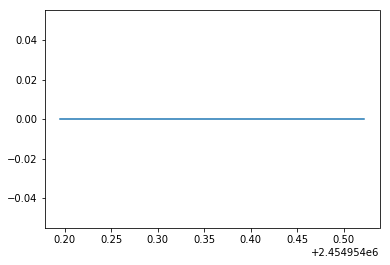

In [256]:
plt.plot(tbl['time'], tbl['flag'])